In [71]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.fft import fft, ifft
from scipy import linalg
from sklearn.preprocessing import PolynomialFeatures

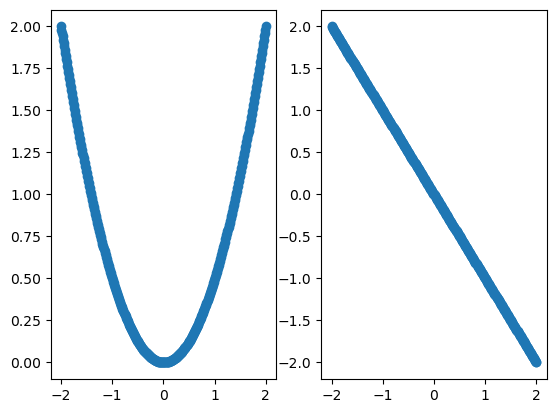

In [54]:
def calc_V(x):
  return np.power(x,2)/2

def calc_dV(x):
  return -np.power(x,1)

def true_response(t):
  return np.exp(-t)

dx = 0.01
x = np.arange(-2,2 + dx, dx)
V = calc_V(x)
dV = calc_dV(x)

fig, ax = plt.subplots(1,2)
ax[0].scatter(x,V)
ax[1].scatter(x,dV)

100%|██████████| 4001/4001 [00:00<00:00, 35216.30it/s]


(array([  1.,   6.,  32., 108., 203., 262., 229., 123.,  28.,   8.]),
 array([-1.30222713, -1.0633356 , -0.82444406, -0.58555253, -0.346661  ,
        -0.10776946,  0.13112207,  0.3700136 ,  0.60890513,  0.84779667,
         1.0866882 ]),
 <BarContainer object of 10 artists>)

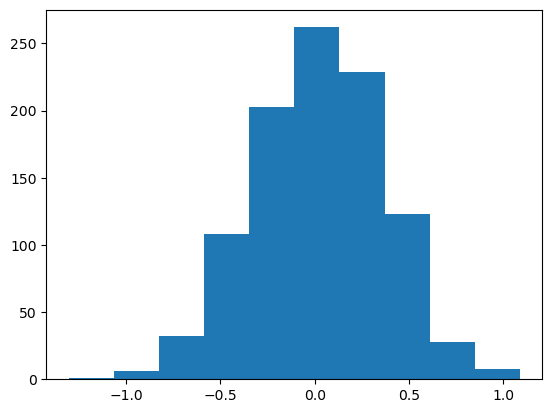

In [63]:
eps = 0.5
Nt = 4001
Ne = 1000
dt = 0.1/4
x0 = np.random.randn(Ne)

for t in tqdm(range(Nt)):
  nu = np.random.randn(Ne)
  x0 = x0 + dt*calc_dV(x0) + eps*np.sqrt(dt)*nu

plt.hist(x0)

In [64]:
eps = 0.5
Nt = 4001
Ne = 1000
dt = 0.1 / 4
delta = dt * 2 # perturbation has to be larger than timestep

timeseries = np.random.randn(Ne, Nt)
score_timeseries = np.copy(timeseries)
perturbed_timeseries = np.copy(timeseries)

timeseries[:, 0] = x0
perturbed_timeseries[:, 0] = np.add(x0,delta)
score_timeseries[:, 0] = np.array([-calc_dV(x) for x in x0]) / (eps**2 / 2)

for t in tqdm(range(1,Nt)):
    nu = np.random.randn(Ne)
    perturbed_timeseries[:, t] = perturbed_timeseries[:, t-1] + dt * calc_dV(np.array(perturbed_timeseries[:, t-1])) + eps * np.sqrt(dt) * nu
    timeseries[:, t] = timeseries[:, t-1] + dt * calc_dV(np.array(timeseries[:, t-1])) + eps * np.sqrt(dt) * nu
    score_timeseries[:, t] = np.array([-calc_dV([x])[0] for x in timeseries[:, t]]) / (eps**2/2)

response = np.mean(perturbed_timeseries - timeseries, axis=0) / delta

ts = np.arange(0, Nt) * dt

100%|██████████| 4000/4000 [00:05<00:00, 793.45it/s]


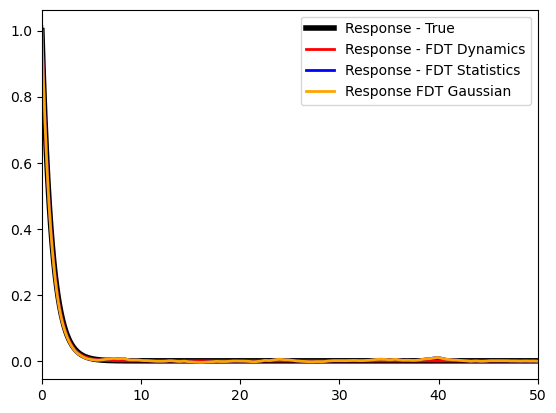

In [65]:
# Calculate response_fdt
response_fdt = np.mean([np.real(ifft(fft(timeseries[j, :]) * ifft(score_timeseries[j, :]))) for j in range(Ne)], axis=0)

# Calculate response_fdt_gaussian
response_fdt_gaussian = np.mean([np.real(ifft(fft(timeseries[j, :]) * ifft(timeseries[j, :]))) for j in range(Ne)], axis=0)
response_fdt_gaussian = response_fdt_gaussian / response_fdt_gaussian[0]

# Calculate mean timeseries and score_timeseries product
mean_product = np.mean([np.mean(timeseries[j, :] * score_timeseries[j, :]) for j in range(Ne)])

# Calculate analytic response function
response_analytic = true_response(ts)

# Plotting
fig, ax = plt.subplots()
ax.plot(ts, response_analytic, color='black', alpha=1, lw=4, label='Response - True')
ax.plot(ts, response, color='red', alpha=1, lw=2, label='Response - FDT Dynamics')
ax.plot(ts, response_fdt, color='blue', alpha=1, linewidth=2, label='Response - FDT Statistics')
ax.plot(ts, response_fdt_gaussian, color='orange', alpha=1, linewidth=2, label='Response FDT Gaussian')

ax.set_xlim(0, ts[-1] / 2)
ax.legend()

plt.show()


In [122]:
# Calculate Koopman modes with EDMD
def polynomial_dictionary(x, max_degree=3):
  """
  Evaluate the polynomial basis [1, x, x^2, ..., x^max_degree] at points x.
  x can be a NumPy array of shape (num_samples,).
  Returns a 2D array of shape (num_samples, max_degree+1).
  """
  num_samples = len(x)
  Psi = np.zeros((num_samples, max_degree+1))
  for d in range(max_degree+1):
    Psi[:, d] = x**d
  return Psi

def EDMD(w, max_degree=3):
  # Calculate K using EDMD
  # Assume first dimension of w is the ensemble
  n_ensemble, n_t = w.shape
  Phi_w = np.zeros((n_ensemble*(n_t - 1), max_degree + 1))
  Phi_wp = np.zeros((n_ensemble*(n_t - 1), max_degree + 1))
  for n in range(n_ensemble - 1):
    Phi_w[n*(n_t - 1):(n + 1)*(n_t - 1),:] = polynomial_dictionary(w[n,:-1], max_degree)
    Phi_wp[n*(n_t - 1):(n + 1)*(n_t - 1),:] = polynomial_dictionary(w[n,1:,], max_degree)

  K = Phi_wp.T @ np.linalg.pinv(Phi_w.T)
  return K

max_degree=3
K = EDMD(timeseries, max_degree)
evals, evecs = np.linalg.eig(K)

# Sort by magnitude of eigenvals descending
idx_sort = np.argsort(-np.abs(evals))
evals = evals[idx_sort]
evecs = evecs[:, idx_sort]

In [123]:
evals

array([1.        , 0.97500719, 0.9507116 , 0.92703598])

=== EDMD Eigs vs. Exact (up to polynomial degree) ===
 Index |  EDMD eval (discrete)  |  cont.rate  |  EXACT mu     | EXACT rate 
    0                    1   -2.10942e-13            1      0.0
    1             0.989802       -1.025      0.99005     -1.0
    2             0.979888     -2.03174     0.980199     -2.0
    3             0.969478      -3.0998     0.970446     -3.0
    4             0.957757     -4.31609     0.960789     -4.0
    5             0.943666     -5.79831     0.951229     -5.0


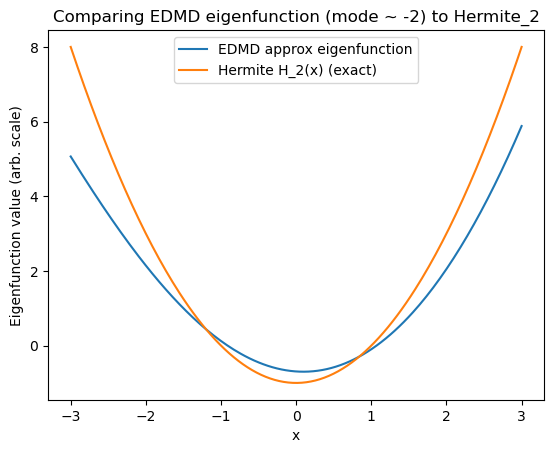

In [102]:
##############################################################################
# 4. Extract EDMD eigenvalues/eigenvectors & compare to exact
##############################################################################

def compare_edmd_to_analytical(K, dt, max_degree=5):
    """
    - K: the EDMD operator in the polynomial space of dimension (max_degree+1).
    - dt: time step used in the data, for mapping discrete-time eigenvalues to continuous rates.
    - max_degree: highest polynomial degree in the dictionary.

    We'll compute K's eigen-decomposition, then compare the discrete eigenvalues mu_i
    to the exact OU discrete eigenvalues e^{-n dt}, and the continuous-time rates
    lam_i = (1/dt)*log(mu_i) to the exact -n, for n up to max_degree.

    We'll also see how the EDMD eigenvectors compare to the Hermite polynomials,
    though we only expect to capture them up to 'max_degree'.
    """
    evals, evecs = np.linalg.eig(K)

    # Sort by magnitude of evals descending, to hopefully align largest modes first
    idx_sort = np.argsort(-np.abs(evals))
    evals = evals[idx_sort]
    evecs = evecs[:, idx_sort]

    # True discrete eigenvalues for OU in a polynomial dictionary sense: mu_n = exp(-n dt)
    # We'll just list n = 0..max_degree for reference
    n_arr = np.arange(max_degree+1)
    mu_exact = np.exp(-n_arr * dt)
    lam_exact = -n_arr  # continuous-time

    # Compare numeric and exact
    print("=== EDMD Eigs vs. Exact (up to polynomial degree) ===")
    print(" Index |  EDMD eval (discrete)  |  cont.rate  |  EXACT mu     | EXACT rate ")
    for i in range(min(max_degree+1, len(evals))):
        mu_i = evals[i]
        # log might fail if mu_i near zero or negative, we handle carefully:
        if np.real(mu_i) > 0:
            lam_i = np.log(mu_i)/dt
        else:
            lam_i = np.nan
        print(f"   {i:2d}   {mu_i:18.6g}   {lam_i:10.6g}   {mu_exact[i]:10.6g}   {lam_exact[i]:6.1f}")

    # NOTE: The eigenvectors in 'evecs' live in the space of polynomial coefficients.
    # If evecs[:, i] is the i-th eigenvector, then the approximate Koopman eigenfunction is
    #   psi_i(x) = sum_{d=0..max_degree} [evecs[d, i] * x^d ].
    # Hermite polynomials themselves appear in a polynomial basis with certain integer coefficients.
    # You can compare them by computing these polynomials on a grid and checking shape.

##############################################################################
# 5. Putting It All Together
##############################################################################

def main():
    # Parameters
    dt = 0.01
    num_steps = 200
    num_paths = 2000
    max_degree = 5  # try capturing up to e^{-4t} mode

    # Generate OU data
    X = generate_OU_paths(num_paths=num_paths, num_steps=num_steps, dt=dt)

    # Perform EDMD with polynomial basis
    K, basis_fun = edmd(X, max_degree=max_degree)

    # Compare numeric vs. exact
    compare_edmd_to_analytical(K, dt, max_degree=max_degree)

    # Optional: Plot an example eigenfunction vs. Hermite
    # Let's pick, e.g., mode i=2 (which might correspond to n=2 = -2 rate)
    # Step 1: find the index i for which the continuous rate is near -2.

    evals, evecs = np.linalg.eig(K)
    idx_sort = np.argsort(-np.abs(evals))
    evals = evals[idx_sort]
    evecs = evecs[:, idx_sort]

    # find index with continuous rate near -2
    lam_approx = np.log(evals)/dt
    i2 = np.argmin(np.abs(lam_approx + 2))  # index where lam ~ -2

    # Construct approximate eigenfunction from evecs[:, i2]
    coeffs = evecs[:, i2]  # shape (max_degree+1,)

    # Evaluate on a grid
    x_grid = np.linspace(-3, 3, 200)
    poly_eval = np.zeros_like(x_grid)
    for d in range(max_degree+1):
        poly_eval += coeffs[d] * (x_grid**d)

    # Up to scaling, the "true" Koopman eigenfunction for n=2 is the Hermite polynomial H_2(x)= x^2 - 1
    hermite_2 = x_grid**2 - 1

    # Compare shapes on a single plot
    plt.figure()
    plt.plot(x_grid, poly_eval, label="EDMD approx eigenfunction")
    plt.plot(x_grid, hermite_2, label="Hermite H_2(x) (exact)")
    plt.title(f"Comparing EDMD eigenfunction (mode ~ -2) to Hermite_2")
    plt.xlabel("x")
    plt.ylabel("Eigenfunction value (arb. scale)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
